In [1]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from gen_ai_hub.proxy.core.proxy_clients import get_proxy_client
from gen_ai_hub.proxy.langchain.openai import (
    ChatOpenAI,
    OpenAIEmbeddings,
)
import base64
import io
from PIL import Image as PILImage


# Initialize the proxy client and models
# proxy_client = get_proxy_client("gen-ai-hub")

# model = ChatOpenAI(proxy_model_name="gpt-4o", proxy_client=proxy_client, temperature=0)
# embedding_model = OpenAIEmbeddings(
#     proxy_model_name="text-embedding-3-small", proxy_client=proxy_client
# )

In [2]:
def display_element(el):
    try:
        if hasattr(el, "metadata") and hasattr(el.metadata, "image_base64"):
            img_data = el.metadata.image_base64
            img_bytes = base64.b64decode(img_data)
            img = PILImage.open(io.BytesIO(img_bytes))
            img.show()
    except Exception as e:
        print(f"Error displaying element: {e}")

In [3]:
from typing import Iterable, Optional
from docling_core.transforms.chunker.hybrid_chunker import HybridChunker
from docling_core.transforms.chunker.tokenizer.base import BaseTokenizer
from docling_core.transforms.chunker.tokenizer.huggingface import HuggingFaceTokenizer
from transformers import AutoTokenizer
from docling_core.transforms.chunker.base import BaseChunk
from docling_core.transforms.chunker.hierarchical_chunker import DocChunk
from docling_core.types.doc.labels import DocItemLabel
from rich.console import Console
from rich.panel import Panel

console = Console(
    width=200,  # for getting Markdown tables rendered nicely
)

EMBED_MODEL_ID = "jinaai/jina-embeddings-v3"

tokenizer: BaseTokenizer = HuggingFaceTokenizer(
    tokenizer=AutoTokenizer.from_pretrained(EMBED_MODEL_ID, trust_remote_code=True),
)
chunker = HybridChunker(tokenizer=tokenizer)


def find_n_th_chunk_with_label(
    iter: Iterable[BaseChunk], n: int, label: DocItemLabel
) -> Optional[DocChunk]:
    num_found = -1
    for i, chunk in enumerate(iter):
        doc_chunk = DocChunk.model_validate(chunk)
        for it in doc_chunk.meta.doc_items:
            if it.label == label:
                num_found += 1
                if num_found == n:
                    return i, chunk
    return None, None


def print_chunk(chunks, chunk_pos):
    chunk = chunks[chunk_pos]
    ctx_text = chunker.contextualize(chunk=chunk)
    num_tokens = tokenizer.count_tokens(text=ctx_text)
    doc_items_refs = [it.self_ref for it in chunk.meta.doc_items]
    title = f"{chunk_pos=} {num_tokens=} {doc_items_refs=}"
    console.print(Panel(ctx_text, title=title))

/Users/I762349/Projects/guideline_rag/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.datamodel.pipeline_options import (
    PdfPipelineOptions,
    PictureDescriptionVlmOptions,
)
from docling.datamodel.base_models import InputFormat

pdf_opts = PdfPipelineOptions(
    do_ocr=True,
    do_table_structure=True,
    do_picture_description=False,  # set to FALSE, will do this later
    generate_page_images=True,  # Seiten‐Renders erzeugen, damit Crops möglich sind
    generate_picture_images=True,
    generate_table_images=True,
    
    # picture_description_options=PictureDescriptionVlmOptions(
    #     repo_id="Qwen/Qwen2.5-VL-7B-Instruct",
    #     prompt="Erklär, was auf dem Bild zu sehen ist. Sei präzise und beschreibe die wichtigsten Details.",
    #     generation_config={
    #         "max_new_tokens": 500,
    #     },
    #     picture_area_threshold=0.1,
    # ),
)

converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(
            pipeline_options=pdf_opts,
        )
    }
)

INPUT_PDFS = [
    "pdfs/001_044l_S1Praevention-Therapie-systemischen-Lokalanaesthetika-Intoxikation-LAST_2025-01-abgelaufen.pdf",
    "pdfs/test/184-001l_S2e_Soziale-Teilhabe-Lebensqualitaet-stationaere-Altenhilfe-Pandemie_2025-03.pdf",
    "pdfs/test/083-053l_S3_Vollkeramische-festsitzende-implantatgetragene-Restaurationen_2025-02.pdf",
    "pdfs/179-009l_S2e_Rehabilitation-untere-Extremitaet-Stehfunktion-Gehfunktion-Querschnittlaehmung_2024-07_1.pdf"
]

res = converter.convert(INPUT_PDFS[3])
doc = res.document

/Users/I762349/Projects/guideline_rag/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
from copy import deepcopy
# doc_1 = deepcopy(doc)
# res_1 = res
# doc_2 = deepcopy(doc)
# res_2 = res

# Image Processing

## Filter small images

Image #/pictures/0

[]



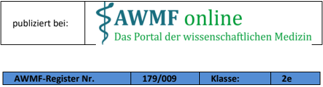

Image #/pictures/1

[]



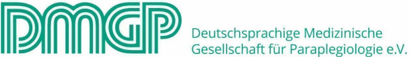

In [8]:
from docling_core.types.doc.document import ImageRef
from IPython.display import HTML

def display_image_obj(image_obj: ImageRef):
    html_image = f'<img src="{image_obj.uri!s}" /><br />'
    display(HTML(html_image))

for image_obj in doc.pictures:
    print(f"Image {image_obj.self_ref}")
    print(image_obj.caption_text(doc=doc))
    print(image_obj.annotations)
    display_image_obj(image_obj.image)
    

In [ ]:
def filter_small_pictures(doc):
    MIN_W, MIN_H = 75, 75

    valid_pics = []
    for pic in doc.pictures:
        w, h = pic.image.size.width, pic.image.size.height
        if w >= MIN_W and h >= MIN_H:
            valid_pics.append(pic)
    doc.pictures = valid_pics

    valid_refs = {doc.body.self_ref}
    for seq in (doc.texts, doc.tables, doc.pictures, doc.groups):
        valid_refs.update(item.self_ref for item in seq)

    all_groups = list(doc.groups) + [doc.body]
    for grp in all_groups:
        grp.children = [r for r in grp.children if r.cref in valid_refs]

filter_small_pictures(doc)
for image_obj in doc.pictures:
    print(f"Image {image_obj.self_ref}")
    print(image_obj.caption_text(doc=doc))
    print(image_obj.annotations)
    display_image_obj(image_obj.image)
    

# TODO got an error with table.image after filtering images (doc 1)

In [ ]:
doc.pictures

## Annotate pictures

In [11]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
vlm = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct", torch_dtype="auto", device_map="auto"  # TODO change to 32B for production
)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")

Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.59s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
image_data = str(doc.pictures[0].image.uri._url)
image_data

In [ ]:
from qwen_vl_utils import process_vision_info
from copy import deepcopy
from docling_core.types.doc.document import PictureDescriptionData

def annotate_picture(picture):
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": str(picture.image.uri._url),
                },
                {"type": "text", "text": "Du bist ein medizinischer Experte. Beschreibe detailliert was du auf diesem Bild siehst. Das Bild stammt aus einer medizinischen Leitlinie."},
            ],
        }
    ]
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, _ = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("mps")  # TODO change to cuda for production

    generated_ids = vlm.generate(**inputs, max_new_tokens=600)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    picture.annotations = [PictureDescriptionData(kind='description', text=output_text[0], provenance='Qwen2.5-VL-3B-Instruct')]  # TODO change model for production

if doc.pictures:
    for picture in doc.pictures:
        annotate_picture(picture)
    doc.pictures[1].annotations

# Tables

## Identify legend table

In [6]:
from transformers import AutoModel
from langchain_core.vectorstores import InMemoryVectorStore
from langchain.embeddings.base import Embeddings

class CustomHFEmbeddings(Embeddings):
    def __init__(self, hf_model):
        self.model = hf_model

    def embed_documents(self, texts: list[str]) -> list[list[float]]:
        return self.model.encode(texts, task="retrieval.passage")

    def embed_query(self, text: str) -> list[float]:
        return self.model.encode([text], task="retrieval.query")[0]

embedder = AutoModel.from_pretrained("jinaai/jina-embeddings-v3", trust_remote_code=True)

lc_embeddings = CustomHFEmbeddings(embedder)

temp_vector_store = InMemoryVectorStore(embedding=lc_embeddings)


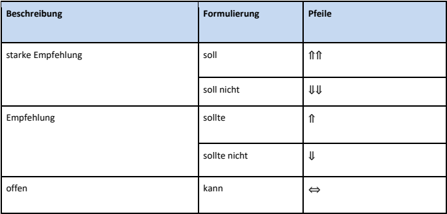

In [9]:
# Collect one string per table (or per cell, as you prefer)
table_texts = []
for table in res.document.tables:
    # Join all cells in this table by rows
    rows = []
    for row in table.data.grid:
        row_text = " \t ".join(cell.text for cell in row)
        rows.append(row_text)
    table_texts.append("\n".join(rows))

temp_vector_store.add_texts(table_texts, ids=[table.self_ref for table in doc.tables])

legend_tabe_candidates = temp_vector_store.similarity_search("Welche Empfehlungsgrade sind definiert? Was bedeuten sie? Welches Symbol wird in der Legende verwendet?", k=3)
legend_table = next(table for table in doc.tables if table.self_ref == legend_tabe_candidates[0].id)
display_image_obj(legend_table.image)

## Create symbol legend

In [ ]:
{
    "A": "Starke Empfehlung",
    "Zwei Pfeile nach oben": "Starke Empfehlung",
    "Zwei Pfeile nach unten": "Starke Empfehlung",
    "B": "Schwache Empfehlung",
    "Ein Pfeil nach oben": "Schwache Empfehlung",
    "Ein Pfeil nach unten": "Schwache Empfehlung",
    "0": "Empfehlung offen",
    "Waagerechter Pfeil": "Empfehlung offen",
}
"{\n"
                '  "A": "Starke Empfehlung",\n'
                '  "⇑⇑": "Starke Empfehlung",\n'
                '  "⇓⇓": "Starke Empfehlung",\n'
                '  "B": "Schwache Empfehlung",\n'
                '  "⇑": "Schwache Empfehlung",\n'
                '  "⇓": "Schwache Empfehlung",\n'
                '  "0": "Empfehlung offen",\n'
                '  "⇔": "Empfehlung offen"\n'
                "}\n"

In [ ]:
legend_table.data.grid

In [ ]:
legend_table.export_to_markdown(doc=doc)

In [ ]:
legend_table.export_to_html(doc=doc)

In [ ]:
# doc_2_table = deepcopy(legend_table)
# doc_2_table_image = deepcopy(str(table.image.uri._url))

In [13]:
def extract_legend_with_html_and_image(table, doc):
    # 1. Hole das HTML (ohne Bild-Tags, das macht der VLM auf der Bild-Ebene)
    table_html = table.export_to_html(doc=doc)

    # 2. Baue Deinen Prompt inkl. Beispiel-Output-Schema
    messages = [{
        "role": "user",
        "content": [
            # a) Bild der Legende
            {"type": "image", "image": str(table.image.uri._url)},
            # b) Anweisung und Beispiel
            {"type": "text", "text":
                "Du bist medizinischer Experte. Aus der abgebildeten Legendentabelle "
                "sollst Du ein Python-Dictionary bauen, das **jedes** Symbol (Pfeile) und "
                "auch jeden Eintrag der ersten Spalte (die Buchstaben A, B, 0) als Key "
                "und als Value die Kurzbeschreibung der Empfehlungsstärke abbildet. "
                "Verwende als Schlüssel **genau den String, den das Symbol darstellt** "
                "(z.B. „⇑⇑“ oder „Ein Pfeil nach oben“) bzw. den Buchstaben selbst.  \n"
                "```json\n"
                "{\n"
                '  "A": "Starke Empfehlung",\n'
                '  "⇑⇑": "Starke Empfehlung",\n'
                '  "⇓⇓": "Starke Empfehlung",\n'
                '  "B": "Schwache Empfehlung",\n'
                '  "⇑": "Schwache Empfehlung",\n'
                '  "⇓": "Schwache Empfehlung",\n'
                '  "0": "Empfehlung offen",\n'
                '  "⇔": "Empfehlung offen"\n'
                "}\n"
                "```"
            },
            # c) Das rohe HTML der Tabelle
            {"type": "text", "text": table_html},
        ],
    }]

    # 3. Template anwenden und Inputs erzeugen
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, _ = process_vision_info(messages)
    inputs = processor(
        text=[text], images=image_inputs,
        padding=True, return_tensors="pt"
    ).to("mps")

    # 4. Generieren und Decoden
    out_ids = vlm.generate(**inputs, max_new_tokens=200)
    trimmed = out_ids[:, inputs.input_ids.shape[1]:]
    result_json = processor.batch_decode(trimmed, skip_special_tokens=True)[0]

    return result_json


legend_json = extract_legend_with_html_and_image(
    legend_table, res.document
)
print(legend_json)


Hier ist das Python-Dictionary, das basierend auf der Legendentabelle erstellt wurde:

```python
{
    "A": "Starke Empfehlung",
    "⇑⇑": "Starke Empfehlung",
    "⇓⇓": "Starke Empfehlung",
    "B": "Schwache Empfehlung",
    "⇑": "Schwache Empfehlung",
    "⇓": "Schwache Empfehlung",
    "0": "Empfehlung offen",
    "⇔": "Empfehlung offen"
}
```

Dieses Dictionary enthält alle notwendigen Schlüssel und Werte gemäß der Beschreibung in der Legendentabelle.


In [ ]:
def create_symbol_legend(table):
    table_text = table.export_to_html(doc=doc)
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": str(picture.image.uri._url),
                },
                {"type": "text", "text": "Du bist ein medizinischer Experte. Auf der abgebildeten Tabelle siehst du, wie in einer medizinischen Leitlinie Empfehlungsgrade dargestellt werden. "
                 "Erstelle ein dictionary, das die Bedeutung der einzelnen Empfehlungsgrade erklärt. Das dictionary soll die Struktur haben: {'Symbol': 'Bedeutung'}. "
                 "Wenn das Symbol im Text vorkommt, benutze es als Schlüssel. "
                 "Wenn das Symbol nicht im Text vorkommt, beschreibe es knapp.\n\n"
                },
                {
                    "type": "text",
                    "text": table_text,
                }
            ],
        }
    ]
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, _ = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("mps")  # TODO change to cuda for production

    generated_ids = vlm.generate(**inputs, max_new_tokens=600)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text[0]

create_symbol_legend(legend_table)

In [ ]:
print(legend_table.export_to_html(doc=doc))

In [ ]:
from docling_core.transforms.serializer.markdown import MarkdownParams


class ImgPlaceholderSerializerProvider(ChunkingSerializerProvider):
    def get_serializer(self, doc):
        return ChunkingDocSerializer(
            doc=doc,
            params=MarkdownParams(
                image_placeholder="",
            ),
        )


chunker = HybridChunker(
    tokenizer=tokenizer,
    serializer_provider=ImgPlaceholderSerializerProvider(),
)

chunk_iter = chunker.chunk(dl_doc=doc.document)

chunks = list(chunk_iter)

In [ ]:
annotations=[PictureDescriptionData(kind='description', text='Das Bild zeigt ein Diagramm, das den Gesundheitszustand oder -problemen in Bezug auf verschiedene Faktoren darstellt. Hier sind die wichtigsten Details:\n\n1. **Gesundheitszustand/-problem**: Dies ist der Anfangspunkt des Diagramms und repräsentiert den Gesundheitszustand oder -problemen, die untersucht werden sollen.\n\n2. **Körperfunktionen und -strukturen**: Diese sind die Grundlagen für die Aktivitäten und Partizipation. Sie umfassen Faktoren wie:\n   - Körperfunktionen\n   - Körperformen\n   - Körperformen\n\n3. **Aktivitäten**: Diese sind die Handlungen, die der Individuum ausgeführt werden können. Sie umfassen:\n   - Kommunikation\n   - Mobilität\n   - Selbstversorgung\n   - Häusliches Leben\n   - Interpersonelle Interaktionen und Beziehungen\n   - Bedeutende Lebensbereiche\n   - Gemeinschafts-, soziales und staatsbürgerliches Leben\n\n4. **Partizipation (Teilhabe)**: Diese sind die Fähigkeiten, die das Individuum in den verschiedenen Aktivitäten ausüben kann. Sie umfassen:\n   - Kommunikation\n   - Mobilität\n   - Selbstversorgung\n   - Häusliches Leben\n   - Interpersonelle Interaktionen und Beziehungen\n   - Bedeutende Lebensbereiche\n   - Gemeinschafts-, soziales und staatsbürgerliches Leben\n\n5. **Umweltfaktoren**: Diese sind die Faktoren, die die Aktivitäten und Partizipation beeinflussen. Sie umfassen:\n   - Kommunikation\n   - Mobilität\n   - Selbstversorgung\n   - Häusliches Leben\n   - Interpersonelle Interaktionen und Beziehungen\n   - Bedeutende Lebensbereiche\n   - Gemeinschafts-, soziales und staatsbürgerliches Leben\n\n6. **Personbezogene Faktoren**: Diese sind die Faktoren, die direkt auf den Gesundheitszustand oder -problemen wirken. Sie umfassen:', provenance='Qwen/Qwen2.5-VL-3B-Instruct')]),

In [ ]:
PictureDescriptionData

In [ ]:
from copy import deepcopy
from docling_core.types.doc.document import PictureDescriptionData
test_picture = deepcopy(res.document.pictures[-1])
test_picture.annotations = [PictureDescriptionData(kind='description', text='manuell eingefügter Text', provenance='johann/manuell')]
test_picture.annotations

In [ ]:
res.document.tables + [res.document.tables[-1]]

In [ ]:
doc.document.pictures[1].label == DocItemLabel.PICTURE

# Table embedding
for identifying the legend table

In [ ]:
# Collect one string per table (or per cell, as you prefer)
table_texts = []
for table in res.document.tables:
    # Join all cells in this table by rows
    rows = []
    for row in table.data.grid:
        row_text = " \t ".join(cell.text for cell in row)
        rows.append(row_text)
    table_texts.append("\n".join(rows))

In [ ]:
table_texts[-1]

In [ ]:
from transformers import AutoModel
from langchain_core.vectorstores import InMemoryVectorStore
from langchain.embeddings.base import Embeddings

class CustomHFEmbeddings(Embeddings):
    def __init__(self, hf_model):
        self.model = hf_model

    def embed_documents(self, texts: list[str]) -> list[list[float]]:
        return self.model.encode(texts, task="retrieval.passage")

    def embed_query(self, text: str) -> list[float]:
        return self.model.encode([text], task="retrieval.query")[0]

embedder = AutoModel.from_pretrained("jinaai/jina-embeddings-v3", trust_remote_code=True)

lc_embeddings = CustomHFEmbeddings(embedder)

vector_store = InMemoryVectorStore(embedding=lc_embeddings)

vector_store.add_texts(table_texts, ids=[table.self_ref for table in doc.tables])

In [ ]:
legend_tabe_candidates = vector_store.similarity_search("Welche Empfehlungsgrade sind definiert? Was bedeuten sie?", k=3)
legend_table = next(table for table in doc.tables if table.self_ref == legend_tabe_candidates[0].id)

In [ ]:
legend_table

In [ ]:
legend_table

In [ ]:
from docling_core.types.doc.document import ImageRef
def display_image_obj(image_obj: ImageRef):
    html_image = f'<img src="{image_obj.uri!s}" /><br />'
    display(HTML(html_image))

display_image_obj(legend_table.image)

In [ ]:
from docling.pipeline.vlm_pipeline import VlmPipeline
from docling.datamodel.pipeline_options import (
    VlmPipelineOptions,
    HuggingFaceVlmOptions,
    ResponseFormat,
    InferenceFramework,
)
from docling.models.picture_description_base_model import NodeItem

# 2. Konfiguriere den VLM-Prompt mit Qwen2.5-VL-7B-Instruct
vlm_opts = VlmPipelineOptions(
    vlm_options=HuggingFaceVlmOptions(
        kind="hf_model_options",
        repo_id="Qwen/Qwen2.5-VL-7B-Instruct",
        prompt=(
            "Bitte analysiere diese Tabelle und erkläre präzise, "
            "welche Informationen sie vermittelt."
        ),
        response_format=ResponseFormat.MARKDOWN,
        inference_framework=InferenceFramework.TRANSFORMERS,
        load_in_8bit=False,       # optional: 4-/8-Bit Quantisierung
        quantized=False,
    )
)

# 3. Erstelle die Pipeline und wickle Dein Bild in ein NodeItem
vlm = VlmPipeline(pipeline_options=vlm_opts)


In [ ]:
node = NodeItem(
    self_ref=legend_table.self_ref,           # the node’s own reference
    children=[],                       # no nested children
    content_layer=legend_table.content_layer, # usually ContentLayer.BODY
)

# 4. Führe die Analyse aus
result = vlm.execute(node, raises_on_error=True)

# 5. Gib das Markdown-Ergebnis aus
print(result.text)

In [ ]:
from docling.models.hf_vlm_model import HuggingFaceVlmModel
from docling.datamodel.pipeline_options import (
    HuggingFaceVlmOptions, ResponseFormat, InferenceFramework, AcceleratorOptions
)
from docling.models.picture_description_base_model import NodeItem

# 1. Baue Deine HuggingFaceVlmOptions wie gehabt
vlm_opts = HuggingFaceVlmOptions(
    kind="hf_model_options",
    repo_id="Qwen/Qwen2.5-VL-7B-Instruct",
    prompt=(
        "Beschreibe bitte präzise, welches Symbol das ist "
        "und welche Bedeutung es in der Legende hat."
    ),
    response_format=ResponseFormat.MARKDOWN,
    inference_framework=InferenceFramework.TRANSFORMERS,
    load_in_8bit=False,
    quantized=False,
)

# 2. Lade das VLM‐Model selbst
hf_model = HuggingFaceVlmModel(
    enabled=True,
    artifacts_path=None,
    accelerator_options=AcceleratorOptions(device="auto"),  # auf Deinem M4-Pro
    vlm_options=vlm_opts,
)


# 3. Schneide das Bild der Legendentabelle schon vorher (table.image)
#    und packe es in ein NodeItem:
node = NodeItem(
    self_ref=legend_table.self_ref,
    parent_ref=legend_table.parent,
    children=[],
    content_layer=legend_table.content_layer,
    image=legend_table.image,
)

# 4. Rufe direkt das Model auf
#    (die Methode kann je Version .process oder .forward heißen; hier nehmen wir .process)
result_node = hf_model.process(node)

# 5. Hol Dir den generierten Text
print(result_node.text)

In [ ]:

# 4. Führe die Analyse aus
result = vlm.execute(legend_table, raises_on_error=True)

# 5. Gib das Markdown-Ergebnis aus
print(result.text)

In [ ]:
from PIL import Image

# Nach der PDF-Konvertierung hast Du:
# res = converter.convert(...)
#    • res.page_images: Dict[int, PIL.Image] mit allen Seitenbildern
#    • doc = res.document mit Deinen TableItems

table_images = []
for table in doc.tables:
    # 1. Seite und BBox auslesen
    prov = table.prov[0]
    page_img = res.page_images[prov.page_no]
    bbox = prov.bbox  # Koords in PDF-Units, Ursprung unten links

    # 2. Koordinaten für PIL umrechnen (Y-Achse von oben)
    left = bbox.l
    upper = page_img.height - bbox.b
    right = bbox.r
    lower = page_img.height - bbox.t

    # 3. Ausschneiden und speichern
    table_img = page_img.crop((left, upper, right, lower))
    table_images.append(table_img)
    # Optional: table.image = table_img  # an das TableItem anhängen

# # Jetzt enthält table_images für jede Tabelle ein PIL-Image.
# # Du kannst sie direkt anzeigen, abspeichern oder an Deinen VLM zur Analyse geben.
# for i, img in enumerate(table_images):
#     img.save(f"table_{i}.png")

In [ ]:
img = table.image or table.to_image(res.source)

img